In [55]:
import numpy as np
import os
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import helper
from feature_optimization import FeatureOptimizer
import feature_opt_functions as funcs
from indices import *

from sklearn.preprocessing import RobustScaler

In [56]:
dictOfStressedImageNames = {}
for v in helper.getStressedImagesNames('stress_date.xlsx'):
    if v is not None:
        dictOfStressedImageNames[v[0]] = v[1]

dictOfReferenceImageNames = {}
for v in helper.getStressedImagesNames('reference_date.xlsx'):
    if v is not None:
        dictOfReferenceImageNames[v[0]] = v[1]

tilesPerGroup = None
with open(os.path.join("subdivs", "tiles_2img_2.json"), 'r') as fout:
    tilesPerGroup = json.load(fout)

train_tiles = tilesPerGroup[0]
test_tiles = tilesPerGroup[1]

train_data = helper.getH_and_S(dictOfStressedImageNames, train_tiles)
train_data_ref = helper.getH_and_S(dictOfReferenceImageNames, train_tiles)
test_data = helper.getH_and_S(dictOfStressedImageNames, test_tiles)
test_data_ref = helper.getH_and_S(dictOfReferenceImageNames, test_tiles)

(92, 4)
(92, 4)


In [57]:
encoder = IndicesClassEncoderEq([NORMP], list(range(1, 12)))

args = { 
    "num_generations":1, 
    "num_parents_mating":3,
    "parent_selection_type":"sss",
    "keep_elitism":1,
    "sol_per_pop":5,
    "mutation_probability":0.25,
    "parallel_processing":8
    }

opt = FeatureOptimizer(encoder, 16,
                        funcs.bhattacharyya_distance, 
                        funcs.spearman_independency, 
                        optimization_method="genetic",
                        optimizer_args=args,
                        informativeness_threshold=0.05, 
                        independency_threshold=0.05,
                        set_independency="geom_mean")

data = [None]*2
data[0] = helper.leaveFinite(train_data[0])
data[1] = helper.leaveFinite(train_data[1])
opt.fit(data, data[1], True, False)

# features BANDS
# opt.selected_features = list(range(11))
# opt.selected_features = opt.private_threshold_dimensionality_reduction(opt.selected_features)

# features FRAC3 16
# opt.selected_features = [515, 243, 13, 1163, 1315, 32, 608, 1191, 486, 1069, 697, 760, 172, 873, 752]

# features NMDIbased 11 + 6
# opt.selected_features = [255, 1080, 22, 127, 1102, 96]

# features NORMP 11 + 6
opt.selected_features = [23, 107, 25, 111, 55, 62]

indices_train_H = helper.leaveFinite(opt.transform_series([train_data[0], train_data_ref[0]])).swapaxes(0, 1)
indices_train_S = helper.leaveFinite(opt.transform_series([train_data[1], train_data_ref[1]])).swapaxes(0, 1)
indices_test_H = helper.leaveFinite(opt.transform_series([test_data[0], test_data_ref[0]])).swapaxes(0, 1)
indices_test_S = helper.leaveFinite(opt.transform_series([test_data[1], test_data_ref[1]])).swapaxes(0, 1)

scaler = RobustScaler(unit_variance=True)

indices_train_H = scaler.fit_transform(indices_train_H)
indices_train_S = scaler.transform(indices_train_S)
indices_test_H = scaler.transform(indices_test_H)
indices_test_S = scaler.transform(indices_test_S)

train_X, train_y = helper.joinData(indices_train_H, indices_train_S)
test_X, test_y = helper.joinData(indices_test_H, indices_test_S)

In [58]:
def getName(feature, mapping):
    raw_name = getIndexName(opt.indicesEncoder.getIndex(feature), mapping)
    parts = str.split(raw_name, '(')

    inform = opt.private_get_informativeness(feature)
    formatted = "{:.3f}".format(inform)

    return parts[0] + "\n(" + parts[1] + "\nDB = " + formatted

mapping = {0: "B1", 1: "B2", 2:"B3", 3:"B4", 4:"B5", 5:"B6", 6:"B7", 7:"B8", 8:"B8A", 9:"B9", 10:"B11", 11:"B12"}
feature_names_local = [getName(feature, mapping) for feature in opt.selected_features]
feature_names = feature_names_local + ["p" + name for name in feature_names_local]

df = pd.DataFrame(train_X, columns=feature_names)
df["Label"] = train_y
df['Label'] = df['Label'].map({0:'Healthy', 1:'Stressed'})

df.head()

,"NORMP\n(B3, B4)\nDB = 0.649","NORMP\n(B9, B11)\nDB = 0.486","NORMP\n(B5, B4)\nDB = 0.458","NORMP\n(B3, B12)\nDB = 0.340","NORMP\n(B2, B7)\nDB = 0.322","NORMP\n(B8A, B7)\nDB = 0.109","pNORMP\n(B3, B4)\nDB = 0.649","pNORMP\n(B9, B11)\nDB = 0.486","pNORMP\n(B5, B4)\nDB = 0.458","pNORMP\n(B3, B12)\nDB = 0.340","pNORMP\n(B2, B7)\nDB = 0.322","pNORMP\n(B8A, B7)\nDB = 0.109",Label
0,-1.883212,-4.894243,-2.606476,-0.369303,1.248231,2.601837,-1.141074,-2.655098,-1.946401,0.606065,3.217005,2.078437,Healthy
1,-1.171037,-4.894243,-0.532241,-1.503580,0.387448,2.601837,-0.732147,-2.655098,-0.142905,-1.010109,1.128515,2.078437,Healthy
2,-0.487173,-4.175802,0.722576,-1.715789,-0.328808,0.139708,-0.356514,-1.796440,-0.167430,-0.419774,0.854476,0.169359,Healthy
3,-0.487173,-4.175802,0.722576,-1.715789,-0.328808,0.139708,-0.356514,-1.796440,-0.167430,-0.419774,0.854476,0.169359,Healthy
4,0.272877,-4.175802,2.590354,-3.017449,-0.683454,0.139708,-0.052985,-1.796440,0.433421,-0.892730,0.297863,0.169359,Healthy


In [59]:
df2 = pd.melt(df, id_vars=["Label"], value_vars=feature_names_local, var_name="Feature", value_name="Value")
df2.head()

df3 = df2[df2["Value"]<10]
df3 = df3[df3["Value"]>-10]

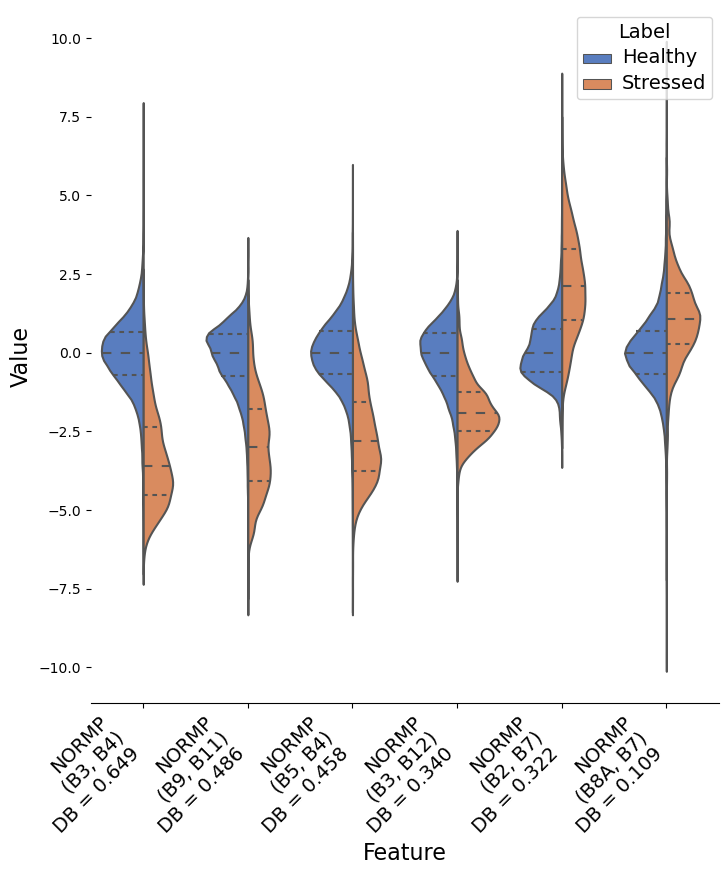

In [60]:
fig, ax = plt.subplots(figsize=(1.5 + 1.1 * len(opt.selected_features), 9))
ax.set_xlabel('Feature', fontsize = 16) 
ax.set_ylabel('Value', fontsize = 16)

sns.violinplot(x="Feature", y="Value", hue="Label", split=True, data=df3, palette="muted",inner='quart')
_ = plt.xticks(rotation=45, ha='right', size=14)
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

sns.despine(left=True)

<Axes: >

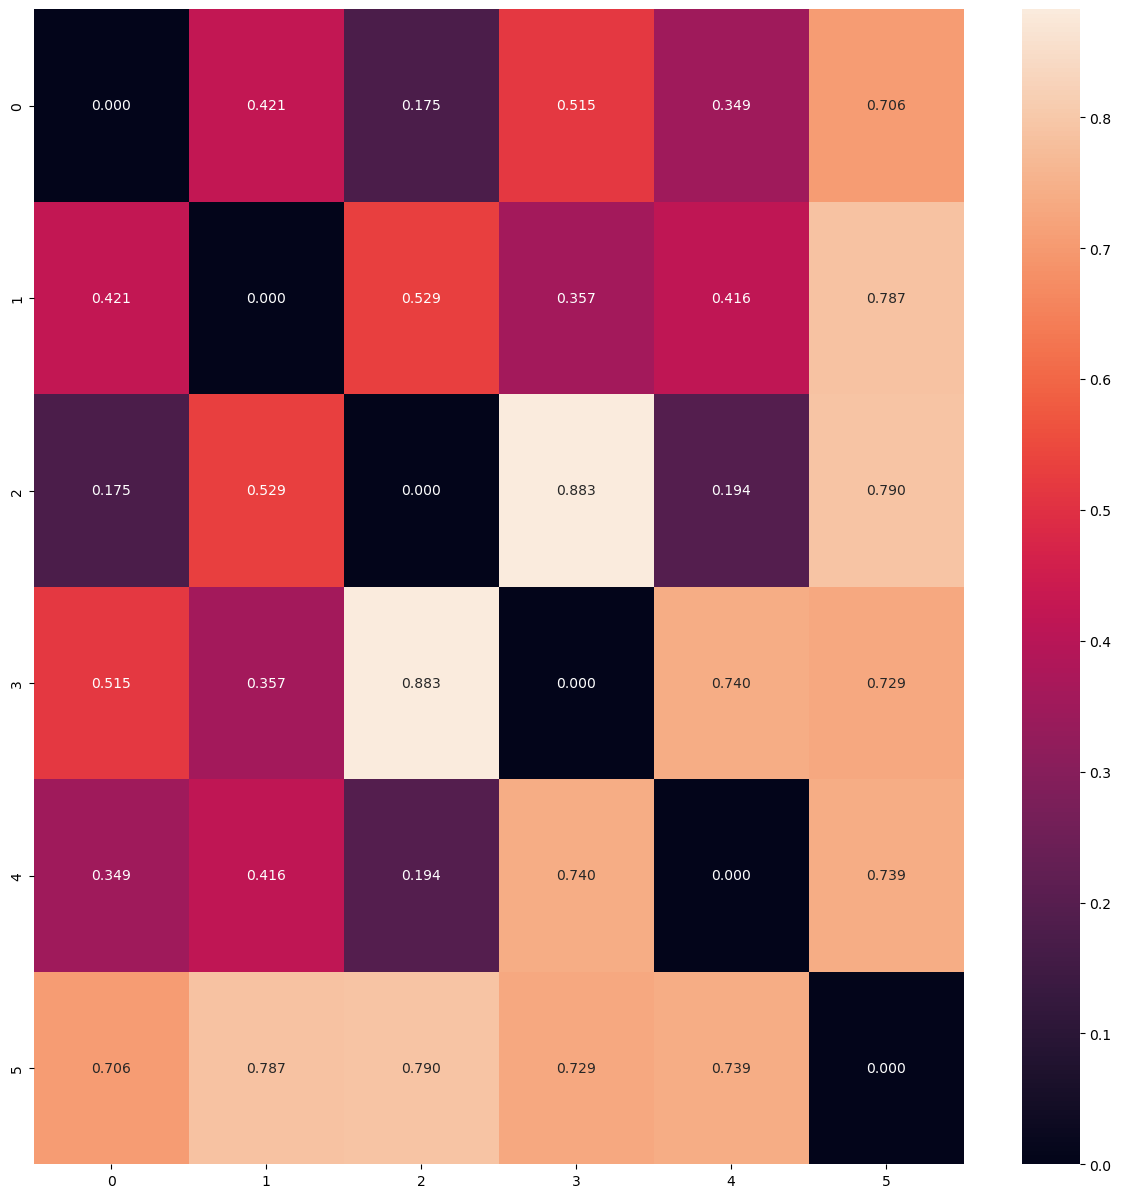

In [61]:
mat = np.empty((len(opt.selected_features), len(opt.selected_features)))

for i in range(len(opt.selected_features)):
    for j in range(len(opt.selected_features)):
        mat[i, j] = opt.private_get_independency(opt.selected_features[i], opt.selected_features[j])

plt.figure(figsize=(15, 15))
sns.heatmap(mat, annot=True, fmt=".3f")